## Large-scale heterogeneities can alter the characteristics of compressive failure and accelerated seismic release
Drew Patton*: Code, analysis, & writer.

Supervisor -- Joern Davidsen: Writer.

Collaborators -- Grzegorz Kwiatek & Thomas Goebel: Experimental measurments, feedback, & writers.

DOI: 10.1103/PhysRevE.108.014131 




----
#### Abstract
Externally stressed brittle rocks fail once the stress reaches a critical threshold. This failure is typically preceded by a noticeable increase in the total energy of acoustic emission (AE) events—known as accelerated seismic release. However, other characteristics of approaching the failure point, such as the presence or absence of variations in the AE size distribution, and whether the failure point can be interpreted as a critical point in a statistical physics sense, vary across experiments. In this study, we demonstrate that large-scale stress heterogeneities induced by notches fundamentally alter the characteristics of the failure point in triaxial compression experiments conducted under a constant displacement rate using Westerly granite samples. Specifically, we observe accelerated seismic release without a clear critical point, and no change in the power law exponent $\epsilon$ of the AE size distribution. This is in contrast to intact samples, which show a significant decrease in $\epsilon$ just before failure. Our findings suggest that the presence or absence of large-scale heterogeneities plays a crucial role in our ability to predict compressive failure in rock.

#### Abstract in Very Simplified Language

When rocks that are under pressure become really stressed, they can break. Before they break, there's usually a big increase in the energy from small shaking events called 'acoustic emission' (AE), think of a small earthquake. This sudden increase in energy is known as 'accelerated seismic release.' But, when we look closely, we notice that other things before the break are not always the same. Sometimes the AE events change in size, and sometimes the moment of breaking acts like a special point in physics called a 'critical point.'

In our research, we discovered something interesting: When we intentionally make the rock stressed in a special way by creating small notches, it changes everything. In tests where we pushed on the rock at a constant speed, using the special, notched Westerly granite samples, we saw the big increase in energy just like before, but there was no special 'critical point,' and the size of the AE events didn't change.

This is different from what happens in regular, unaltered rocks, where the AE events change size right before the rock breaks. What we learned is that whether or not there are these special changes before a rock breaks depends on whether there are irregularities in the rock's stress, like the notches we created.

Our discovery helps us understand how rocks break, and it shows that these irregularities in stress are important in predicting when rocks will break with a special emphasis on earthquake prediction. 


#### Description:
This notebook shows the data cleaning and data analysis used in this study. 

Our goal is to show:

I) the triaxial compression experiment & its characteristics

II) the statistical mechanics behind fracture

III) our results--the differences between a notched rock and an intact rock sample 


In [1]:
# Import Libraries...

import numpy as np # For vector operations.

# For Plotting & Interactive Plotting.
import matplotlib.pyplot as plt 
import seaborn as sns 
import cmocean 
import matplotlib as mpl 
import ipywidgets as widgets 
from matplotlib.widgets import RectangleSelector 
from mpltools import annotation 

# For file & data management.
import pandas as pd # For data manipulation.
import os # For file path operations.
import shutil # For file path operations.
import re # For regular expressions.
import pathlib # For file path operations.
import mat4py # For loading .mat files.
from mat4py import loadmat # For loading .mat files.
import subprocess # For running shell commands.

# Statistics Libraries.
import bootstrapped  # For bootstrapping statistics.
import bootstrapped.bootstrap as bs 
import bootstrapped.stats_functions as bs_stats
import mpmath # For high precision statistics.
import powerlaw # For fitting power law distributions.
import scipy
import scipy.stats as stats # For statistics.
import sklearn.metrics
from sklearn import datasets, linear_model 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import DistanceMetric
from scipy.spatial import distance
from scipy import optimize

# Misc.
from IPython.utils import io # For suppressing output.
import numba # For speeding up code.

# Plotting in a certain scientific style.
plt.style.use(['science','notebook','grid'])
plt.rcParams.update({
    "text.usetex": True
})

### I.i) Data Retrieval

    To begin, we need to take the Westerly granite raw datasets obtained from the (triaxial compression) experiments, and extract the data we want. There are two datasets of particular interest for this study:

#### Acoustic Emission Dataset
    We want to take the time, adjusted amplitude, polarity, and the 3D-spatial coordinates: x,y,z.

#### Force-Displacement Dataset
    We want to take the time, force, and displacement.

In [2]:
# Obtain directory path.
main_path = 'C:/Users/Drew/Projects/Rock_Fracture/'
raw_data_path = 'RawData/'
dirpath = main_path + raw_data_path

# Get the directory tree for the data.
temp_tree = os.walk(dirpath) # Yields a 3-tuple (dirpath, dirnames, filenames).
dirnames = next(temp_tree)[1] # The directories containing the raw datasets.
N = len(dirnames) # Number of datasets.

df = dict() # DataFrame containing the Westerly granite datasets with relevant data.
for i in range(0,N):
    '''
    Going through each Westerly granite experiment and taking the acoustic emission and force-displacement datasets as a single dataframe.
    '''
    df[dirnames[i]] = {} # Store each dataset.
    sample_dir_tree = os.walk(main_path+raw_data_path+dirnames[i]) # Get the directory tree for the data.
    dir_properties = next(sample_dir_tree) 
    sample_name = dir_properties[0] # The Westerly granite samples' directory path.
    filenames = dir_properties[2] # The relevant sub-dataset from the respective Westerly granite sample.

    # Extract the relevant data and combine to a single dataset for the respective Westerly granite sample.
    for j in range(0,len(filenames)):
        data = loadmat(sample_name +"/"+ filenames[j]) # Loading the respective .mat file.
        if filenames[j][0] == 'A': # If Acoustic Emission dataset.

            # Acoustic Emission Data.
            key_properties = ['Time','AdjAmp','Polarity','x','y','z']
            key_names = ['Time','AdjAmp','pol','X','Y','Z']

        else:
            
            # Force-Displacement Data.
            key_properties = ['Time_Force','Force','Displacement']
            key_names = ['Time','Force']

        data_keys = list(data.keys()) # The keys for the respective .mat file.
        # Combining the relevant data into a single pandas dataframe.
        for key in range(0,len(data_keys)):
            if data_keys[key] == 'Force':
                df[dirnames[i]]['Force'] = np.copy(data['Force']).ravel()
            elif data_keys[key] == 'force':
                df[dirnames[i]]['Force'] = np.copy(data['force']).ravel() # Some of the files contain a lowercase 'f.' Checking for these cases.
            else:
                try: # Some of the files contain a 'Displacement' field. Checking for these cases.
                    df[dirnames[i]][key_properties[key]] = np.copy(data[key_names[key]]).ravel()
                except: 
                    None
                    
samples = dirnames # The Westerly granite samples' names.

### I.ii) Triaxial Compression Experiment Characteristics & Transformations
    There are a few characteristics from the triaxial compression experiments that are of particular interest:

#### Time
    The first is the time at which the sensors detected an acoustic emission (AE) event. This allows us to find the rate of change in the characteristics as approaching failure.

#### Number of Acoustic Emission Events
    The second is the number of AE events.

#### Energy
    The third is the energy. This is obtained as follows:
    Squaring the adjusted amplitude yields a relative energy metric:

\begin{align}
    E_{AE} = \dfrac{1}{N}\sum_{j=1}^{N}(A_{j}D_{j})^{2} = \left(\text{AdjAmp}\right)^{2} \nonumber
\end{align}

Here, $N$ is the number of acoustic emission sensors, $A$ is the first P-wave amplitude at sensor $j$, and $D$ is the distance to sensor $j$.

#### Polarity
    The fourth is the polarity. The polarity showcases which dominant dynamics are play in the fracturing process. For example, we would expect compaction to play a significant role due to the high confining pressure introduced in the triaxial compression. Yet, it is possible that this is may or may not necessarily be the case when we insert a cision in the form of a notch.

#### Differential Stress
    The fifth and final is the differential stress, which is used as the independent variable from the triaxial compression experiments.

Subtracting the pressure due to the confining oil, $P_{c}$, effectively measuring only the pressure being applied as the displacement increase:
\begin{align}
    \sigma_{\Delta} &= \sigma - P_{c}\\ \nonumber
    &= \dfrac{F}{\pi r^{2}} - P_{c}\\ \nonumber
    &= \dfrac{F}{\pi r^{2}} - 75  \nonumber
\end{align}





In [3]:

# Define functions for calculating the acoustic emission energy and differential stress.
def get_energy(AdjAmp):
    '''
    Calculates the acoustic emission energy by squaring the adjusted amplitude. Please note that this is a relative energy, i.e., not in an absolute unit, like joules. 

    Parameters:
    -----------
        AdjAmp -- An Nx1 array containing the adjusted amplitude.

    Returns:
    --------
        energy -- The acoustic energy released by microcrack events as a result of being compressed.
    '''
    energy = AdjAmp**2
    return energy

def differential_stress(Force,radius):
    '''
    Calculates the differential pressure. Simply take the current pressure felt by the sample and subtract is by the confining pressure.
    
    Parameters:
    -----------
         Force -- An Nx1 array containing the force acting on the rock sample.
        radius -- The radius of the rock sample.

    Returns:
    --------
        Diff_stress -- The calculated differential stress at each measured force value.
    '''
    N = len(Force) # The number of force measurements.
    Diff_stress = np.zeros(N)
    for i in range(0,N):
        Diff_stress[i] = (Force[i]-Force[0])/(np.pi*radius**2)*1000
    return Diff_stress

# Assign the samples' radii.
Radii = [26.85,20,20,20,20,20,20]
for i in range(0,len(samples)):
    df[samples[i]]['Radius'] = Radii[i]

# Retrieve the (relative) energy and differential stress for each dataset.
for sample in samples:
    
    df[sample]['Energy'] = get_energy(df[sample]['AdjAmp'])
    if sample == 'Wgn19': # Wgn19 needs to be accounted for as a manual differential stress calculation; the rest were calculated before hand.
        Force = df[sample]['Force']
        radius = df[sample]['Radius']
        Confining_Pressure = 75 # a constant confining pressure in MPa.
        N = len(Force) # The number of force measurements.
        Diff_stress = np.zeros(N)
        for i in range(0,N):
            Diff_stress[i] = Force[i]/(np.pi*radius**2) - Confining_Pressure
        df[sample]['Diff_stress'] = Diff_stress
    else:
        df[sample]['Diff_stress'] = differential_stress(df[sample]['Force'],df[sample]['Radius'])
        


### I.iii) The Fracture Experiments
With the differential stress and time, we can see the fracture experiment in action as the temporal evolution of the differential stress, as well as the divergence of acoustic emission (AE) energy and AE numbers. 

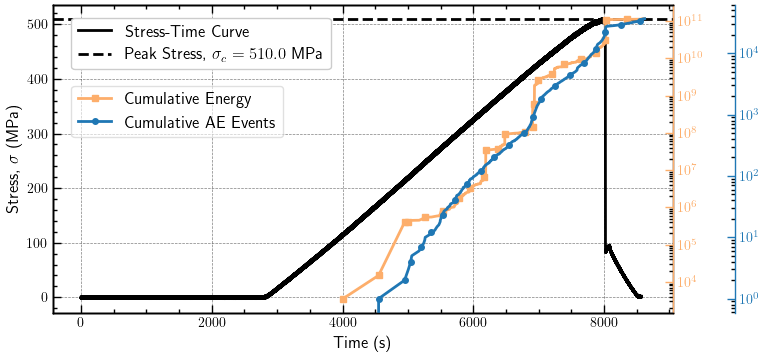

In [5]:
sample = 'Wgrn05' # simply change the sample name to one of interest: 'Wgp01','Wgr02','Wgrn04','Wgrn05','Wgrn07,'Wgrn08', and 'Wgn19'

# Retrieve important experiment measurements.
dE = np.cumsum(df[sample]['Energy']) # The cumulative energy.
dN = range(0,len(df[sample]['Energy'])) # The cumulative AE number.
Time = df[sample]['Time'] # The time of each AE event.
Time_Force = df[sample]['Time_Force'] # The time of each force measurement.
Diff_Stress = df[sample]['Diff_stress'] # The differential stress at each force measurement.
Peak_Stress = max(Diff_Stress) # The peak differential stress.

# Plot Parameters
color_stress = 'black'
color_energy = '#fdae6b'
color_number = 'tab:blue'
label_size = 12
tick_size = 10

# Plot the stress-time, Cumulative Energy-time, and Cumulative AE Number-time curves.
fig = plt.figure(figsize=(8,4))

# Stress-time curve
ax = fig.add_subplot(111)
ax.plot(Time_Force,Diff_Stress,color='black',label=r'Stress-Time Curve')
ax.set_xlabel(r'Time (s)', size = label_size)
ax.set_ylabel(r'Stress, $\sigma$ (MPa)', size = label_size,color=color_stress)
ax.tick_params(axis='y',labelsize=tick_size, colors=color_stress)
ax.tick_params(axis='x',labelsize=tick_size)
ax.axhline(max(df[sample]['Diff_stress']),color=color_stress,ls='dashed',lw=2,label = r'Peak Stress, $\sigma_{c} = '+str(np.round(Peak_Stress))+'$ MPa')

# Cumulative AE Energy curve
ax1 = ax.twinx()
lns1 = ax1.plot(Time,dE,marker='s',markersize=4,markevery=0.03, label=r'Cumulative Energy',color=color_energy)
ax1.set_yscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelsize = tick_size, colors=color_energy)
ax1.spines['right'].set_color(color_energy)
ax1.spines['right'].set_position(('axes',1))

# Cumulative AE Number curve.
ax2 = ax.twinx()
lns2 = ax2.plot(Time,dN,color='tab:blue',marker='o',markersize=4,markevery=0.03, label=r'Cumulative AE Events')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelsize=tick_size, colors=color_number)
ax2.spines['right'].set_color(color_number)
ax2.spines['right'].set_position(('axes',1.1))

# Legends and grid.
ax1.grid(False)
ax2.grid(False)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc=(0.03,0.57),prop={'size':label_size},framealpha=0.6)

ax.legend(loc=(0.03,0.79),prop={'size':label_size})

### I.iv) Peak Stress
For the purpose of this experiment, we consider the peak stress the so-called critical point, which we denote as $\sigma_{c}$. Beyond this point, the instrument becomes oversaturated with a high rate of AE events, effectively nulling the AE measurements and complicating the analysis. Our window of interest is then from where the stress begins to increase up to peak stress.

In [6]:
for sample in samples:
    '''
    To create the window of interest, we need to:
    Find the starting point at which the force begins to increase and eliminate all data before this point.
    Find the peak stress and eliminate the data after this point.
    '''
    # Get peak stress, \sigma_{c}.
    Stress = df[sample]['Diff_stress']
    df[sample]['Full Diff_stress'] = Stress
    sigma_c = np.max(Stress)
    df[sample]['peak_stress'] = sigma_c # Store the peak stress.

    # Get time window for force-displacement data.
    Time_f = df[sample]['Time_Force']
    df[sample]['Full Time_Force'] = Time_f
    f_begin = np.where(Stress > 10)[0][0] # The force begins to increase at a stress of 10 MPa.
    f_peak = np.where(Stress == sigma_c)[0][0] # The peak force.
    tf_begin = Time_f[f_begin] # The time at which the force begins to increase.
    tf_peak = Time_f[f_peak] # The time at which the peak force is reached.

    # Get time window for AE data.
    Time_AE = df[sample]['Time']
    AE_begin = np.where(Time_AE >= tf_begin)[0][0]
    AE_peak = np.where(Time_AE >= tf_peak)[0][0]

    # Replace the data with the respective time windows.
    AE_keys = ['Time','AdjAmp','Polarity','x','y','z','Energy']
    for key in AE_keys:
        df[sample][key] = df[sample][key][AE_begin:AE_peak]
    force_keys = ['Time_Force','Force','Diff_stress','Displacement']
    for key in force_keys:
        try:
            df[sample][key] = df[sample][key][f_begin:f_peak]
        except:
            None


#### I.v) Fracture Experiment within window of interest

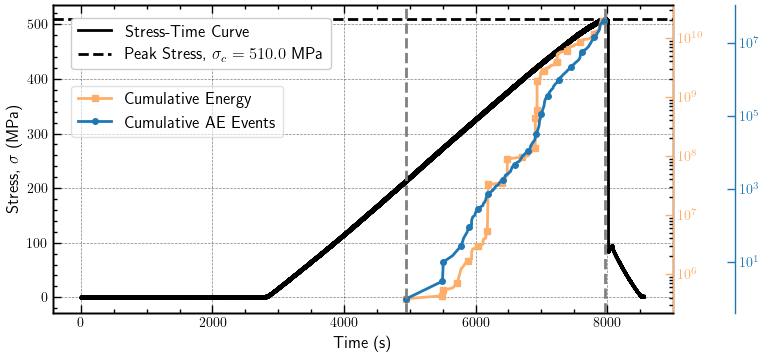

In [430]:
sample = 'Wgrn05'
# Retrieve important experiment measurements.
N = range(1,len(df[sample]['Energy'])+1)
dE = np.cumsum(df[sample]['Energy']) # The cumulative energy.
dN = N # The cumulative AE number.
Time = df[sample]['Time']
Time_Force = df[sample]['Full Time_Force']
Diff_Stress = df[sample]['Full Diff_stress']
Peak_Stress = max(Diff_Stress)

# Plot Parameters
color_stress = 'black'
color_energy = '#fdae6b'
color_number = 'tab:blue'
color_window = 'grey'
label_size = 12
tick_size = 10

# Plot the stress-time, Cumulative Energy-time, and Cumulative AE Number-time curves.
fig = plt.figure(figsize=(8,4))

# Stress-time curve
ax = fig.add_subplot(111)
ax.plot(Time_Force,Diff_Stress,color='black',label=r'Stress-Time Curve')
ax.set_xlabel(r'Time (s)', size = label_size)
ax.set_ylabel(r'Stress, $\sigma$ (MPa)', size = label_size,color=color_stress)
ax.tick_params(axis='y',labelsize=tick_size, colors=color_stress)
ax.tick_params(axis='x',labelsize=tick_size)
ax.axhline(max(df[sample]['Diff_stress']),color=color_stress,ls='dashed',lw=2,label = r'Peak Stress, $\sigma_{c} = '+str(np.round(Peak_Stress))+'$ MPa')

# Cumulative AE Energy curve
ax1 = ax.twinx()
lns1 = ax1.plot(Time,dE,marker='s',markersize=4,markevery=0.03, label=r'Cumulative Energy',color=color_energy)
ax1.set_yscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelsize = tick_size, colors=color_energy)
ax1.spines['right'].set_color(color_energy)
ax1.spines['right'].set_position(('axes',1))

# Cumulative AE Number curve.
ax2 = ax.twinx()
lns2 = ax2.plot(Time,dN,color='tab:blue',marker='o',markersize=4,markevery=0.03, label=r'Cumulative AE Events')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelsize=tick_size, colors=color_number)
ax2.spines['right'].set_color(color_number)
ax2.spines['right'].set_position(('axes',1.1))

# Window of Interest
Time_left = Time_Force[np.where(Time_Force > Time[0])[0][0]]
Time_right = Time_Force[np.where(Time_Force > Time[-1])[0][0]]
plt.axvline(Time_left,color=color_window,linestyle='dashed')
plt.axvline(Time_right,color=color_window,linestyle='dashed')

# Legends and grid.
ax1.grid(False)
ax2.grid(False)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc=(0.03,0.57),prop={'size':label_size},framealpha=0.6)

ax.legend(loc=(0.03,0.79),prop={'size':label_size})

### II.i) Power Laws & Magnitude of Completeness
Earthquakes have the amazing property of the time duration, $\tau$, and size, S, following a scale-free, power law distribution:
\begin{align}
    P(S)dS = S^{-b}dS \nonumber
\end{align}

This scale-free property implies that a power-law can be observed in lab-scale rock fracture experiments. Indeed, we can see a power-law in the form of the energy as such:
\begin{align}
    P(E_{AE})dE_{AE} = E_{AE}^{-\epsilon}dE_{AE} \nonumber
\end{align}
 To observe this, we can set up a complementary cumulative distribution function (CCDF):

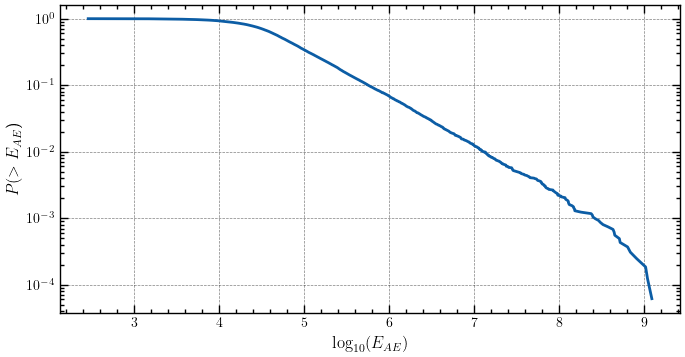

In [15]:
sample = 'Wgrn05'

# Get the survival function (CCDF).
ccdf = powerlaw.ccdf(df[sample]['Energy'])
mag = np.log10(ccdf[0])

# How does the CCDF look like?
fig = plt.figure(figsize=(8,4))
plt.plot(mag,ccdf[1])
plt.yscale('log')
plt.xlabel(r'$\log_{10}(E_{AE})$',size=label_size)
plt.ylabel(r'$P(>E_{AE}$)',size=label_size)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)

plt.show()



Immediately what one would notice is at the beginning there is no power law behaviour. This can be attributed to noise obscuring the low energy events. At some point, a power law is evident, which is where a straight line can be drawn in the log-log scale revealing the exponent $\epsilon$--the component we heavily care for. The point where the power law begins is called the magnitude of completeness--we want to find this to get a good estimate of $\epsilon$.

### II.ii) Approach to finding the magnitude of completeness
To find the magnitude of completeness, we will implement a maximum likelihood estimator (MLE)*. The MLE will evaluate ranges starting from the lowest energy to the highest energy. When the $\epsilon$ value becomes statistically equal, and the p-value comparing a power law increases, this is where the power law begins, and thus the value for the magnitude of completeness.

*The MLE Fortran code was written by Jordi Baro in his previous work:

J. Baró et al., Experimental Evidence of Accelerated Seismic Release without Critical Failure
in Acoustic Emissions of Compressed Nanoporous Materials,
Phys. Rev. Lett. 120, 245501 (2018)

In [16]:
# Save the data!
def save(data, file_path, file_name):
    """
    Description:
    ------------
    It's always important to save your data especially if you're manually making the data by hand.
    
    Parameters:
    -----------
                data     : The list or array of data the user wishes to save.
                file_path: The directory path the user wishes to save the data at.
                file_name: The name of the file the user wishes to save the data as.
                
    Returns:
    --------
    Nothing.
    
    """
    #cwd = os.getcwd()
    new_file = open(file_path + '\\' + file_name,'w')
    for i in range(len(data)):
        new_file.write(str(data[i])+'\n')
    new_file.close()
    
# Make the file in the new folder
data = np.sort(df[samples[4]]['Energy'])
file_path = 'C:/Users/Drew/Projects/Rock_Fracture/External_Code' # Change if need be.
file_name = 'Energy_sorted.sorted'
save(data,file_path,file_name) # Save the data.


In [17]:
def ExponentMap():
    '''
    Description:
    ------------
        This function runs the 2D_EM_continuum_p_val.f90 fortran code.
        The code is calculates maximum likelihood of differing energy windows to find the best fit power law exponent. 
        The code outputs a file called ".EMap" which contains the energy window, (Emax,Emin); the best fit power law exponent, /epsilon; the exponent uncertainty; the number of points in the energy window, n; the maximum likelihood value, kmax; and the p-value, p, respectively.  

    Parameters:
    -----------
        None

    Returns:
    --------
        None
    '''
    path = "C:/Users/Drew/Projects/Rock_Fracture/External_Code"
    file = path+"/Energy_sorted"
    with io.capture_output() as captured: # Stops the fortran code from printing to the console.
        %cd $path
        ! gfortran 2D_EM_continuum_p_val.f90
        ! .\a $file

for sample in samples:
    '''
    This for loop runs the fortran code for each sample and retrieves the power law exponents and energy windows.
    '''
    #Sort the Energy data
    data = np.sort(df[sample]['Energy'])
    file_path = 'C:/Users/Drew/Projects/Rock_Fracture/External_Code'
    file_name = 'Energy_sorted.sorted'
    # Save as a file to be input into the fortran code.
    save(data,file_path,file_name) 

    # get the power law exponent map for a shifting energy window, saved as a .EMap file.
    ExponentMap()

    # Load the power law exponent map data.
    Emap = np.loadtxt('Energy_sorted.EMap')
    Emap = np.array(Emap) # Make the data an array.
    Emin = Emap[:,0] # The minimum energy for each energy window.
    Emax = Emap[:,1] # The maximum energy for each energy window.
    Exponent = Emap[:,2] # The power law exponents for each energy window.
    Exponent_error = Emap[:,3] # The error in the power law exponents for each energy window.
    p_value = Emap[:,6] # The p_value for each energy window.

    # We are interested in the largest moving energy window--starting from the minimum energy moving towards the maximum energy.
    # That is, we hold the maximum energy constant, and shift the minimum energy. Then we take the power law exponent for each these energy windows.
    Largest_Window_Index = np.where(Emax == np.max(Emax))[0] # The index of the largest energy window.
    df[sample]['Emin'] = Emin[Largest_Window_Index]
    df[sample]['Exponent'] = Exponent[Largest_Window_Index]
    df[sample]['Exponent_error'] = Exponent_error[Largest_Window_Index]
    df[sample]['p_value'] = p_value[Largest_Window_Index]


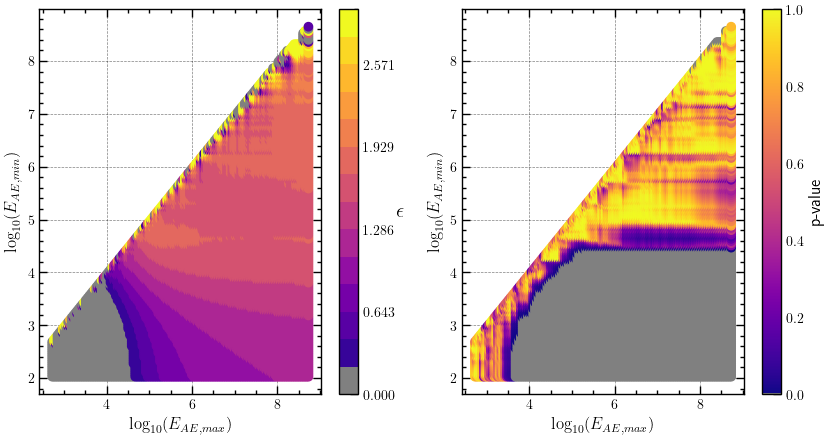

In [18]:
def Exponent_Map_plot(Emap):
    '''
    Description:
    ------------
        This function plots the power law exponent & p-value map for a given energy window from the .EMap file.

    Parameters:
    -----------
        Emap -- The data from the .EMap file.

    Returns:
    --------
        N/A
    '''

    # Load the power law exponent map data.
    Emin = Emap[:,0] # The minimum energy for each energy window.
    Emax = Emap[:,1] # The maximum energy for each energy window.
    Exponent = Emap[:,2] # The power law exponents for each energy window.
    Exponent_error = Emap[:,3] # The error in the power law exponents for each energy window.
    p_value = Emap[:,6] # The p_value for each energy window.

    Mmax = np.log10(Emax)
    Mmin = np.log10(Emin)

    #========= Creating a colormap to discretize the colours =========

    cmap = plt.cm.plasma  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0, 3.0, 15)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

    p_map = ax[1].scatter(Mmax, Mmin, c=p_value,vmin =0,vmax=1.0,cmap=cmap)
    ax[1].set_xlabel(r'$\log_{10}(E_{AE,max})$',size=label_size)
    ax[1].set_ylabel(r'$\log_{10}(E_{AE,min})$',size=label_size)
    ax[1].tick_params(labelsize=tick_size)
    cbar = fig.colorbar(p_map)
    cbar.ax.locator_params(nbins=5)
    cbar.ax.tick_params(labelsize=tick_size)
    cbar.ax.set_ylabel(r'p-value',size=label_size)

    Exp_map = ax[0].scatter(Mmax,Mmin,c= Exponent,cmap=cmap,norm=norm)
    ax[0].set_xlabel(r'$\log_{10}(E_{AE,max})$',size=label_size)
    ax[0].set_ylabel(r'$\log_{10}(E_{AE,min})$',size=label_size)
    ax[0].tick_params(labelsize=tick_size)
    cbar = fig.colorbar(Exp_map)
    cbar.ax.locator_params(nbins=5)
    cbar.ax.tick_params(labelsize=tick_size)
    cbar.ax.set_ylabel(r'$\epsilon$',size=15,rotation = 0)

# Load the power law exponent map data.
Emap = np.loadtxt('Energy_sorted.EMap')
Emap = np.array(Emap) # Make the data an array.
Emin = Emap[:,0] # The minimum energy for each energy window.
Emax = Emap[:,1] # The maximum energy for each energy window.
Exponent = Emap[:,2] # The power law exponents for each energy window.
Exponent_error = Emap[:,3] # The error in the power law exponents for each energy window.
p_value = Emap[:,6] # The p_value for each energy window.

Exponent_Map_plot(Emap)

#### II.iii) Exponent & p-value map slice:
To create robustness, let us take only the window that contains the smallest energy to the largest energy. That would be the entire energy window. From the above figure, we can see a range of values. Clearly any p-value with zero value is outside the powerlaw; any energy window close to the maximum value is small. This creates a straight line of which we are not interested in. So, the true power law behaviour must line inbetween. Indeed, the power law begins where the grey ends:

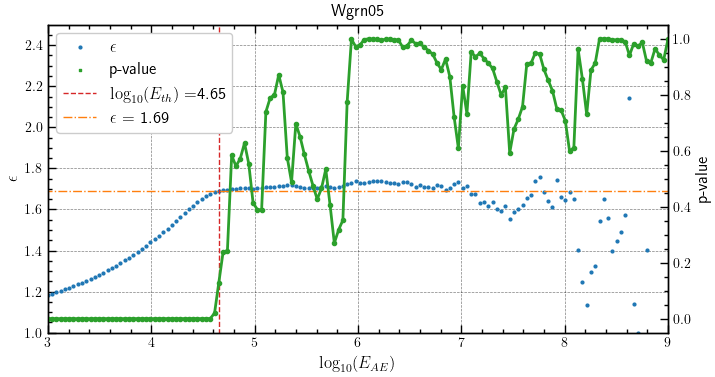

In [19]:
sample='Wgrn05' # Again, one could change the sample.

# Variable of interest
Emin = df[sample]['Emin']
Exponent = df[sample]['Exponent']
Exponent_error = df[sample]['Exponent_error']
p_value = df[sample]['p_value']

# Plot Parameters
color_exponent = 'tab:blue'
color_p = 'tab:green'
label_size = 12 
tick_size = 10


index = np.where(p_value > 0.05)[0][0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))

# Plot of the power law exponents as the energy window decreases.
ax.scatter(np.log10(Emin),Exponent,color=color_exponent,s=4,label='$\epsilon$')
ax.scatter([],[],color=color_p,s=4,label='p-value',marker='s')
ax.set_ylim(1,2.5)
ax.set_xlabel('$\log_{10}(E_{AE})$',size=label_size)
ax.set_ylabel('$\epsilon$',size=label_size)
ax.set_xlim(3,9)
ax.set_title(sample,size=label_size)
ax.tick_params(labelsize=tick_size)
ax.vlines(np.log10(Emin[index]),0,4,linestyle='--',color='tab:red',label='$\log_{10}(E_{th}) = $'+str(np.round(np.log10(Emin[index]),2)),linewidth=1)
ax.hlines(Exponent[index],0,9,linestyle='-.',color='tab:orange',label='$\epsilon$ = {0}'.format(np.round(Exponent[index],2)),linewidth=1)

# Plot of the power law p-values as the energy window decreases.
ax1 = plt.twinx(ax)
ax1.plot(np.log10(Emin),p_value,'-o',color='tab:green',markersize=3,label='p-value')
ax1.set_ylabel('p-value',size=label_size)
ax1.tick_params(labelsize=tick_size)
ax.legend(loc='upper left',fontsize=label_size)

# Grids.
ax1.grid(False)

### II.iv) Magnitude of Completeness

The magnitude of completeness can be approximated by where the exponent, $\epsilon$, begins to follow a statistically straight line. This confidently starts when the p-value is at a larger value then the significance $0.05$--where the red vertical line intersects.

In [20]:
for i in range(0,len(samples)):
    '''
    Find the magnitude of completeness and take only the data above this magnitude.
    '''
    index = np.where(df[samples[i]]['p_value'] > 0.05)[0][0] # p-value is greater than significance.
    mag_comp = np.log10(df[samples[i]]['Emin'][index])
    full_range_epsilon = df[samples[i]]['Exponent'][index]
    full_range_epsilon_unc = df[samples[i]]['Exponent_error'][index]
    df[samples[i]]['Magnitude of completeness'] = mag_comp  
    df[samples[i]]['Epsilon'] = full_range_epsilon

    index = np.where(np.log10(df[samples[i]]['Energy']) > df[samples[i]]['Magnitude of completeness'])[0]
    AE_keys = ['Time','AdjAmp','Polarity','x','y','z','Energy']
    for key in AE_keys:
        df[samples[i]][key] = df[samples[i]][key][index]
        

Text(0.5, 1.0, 'Wgrn05')

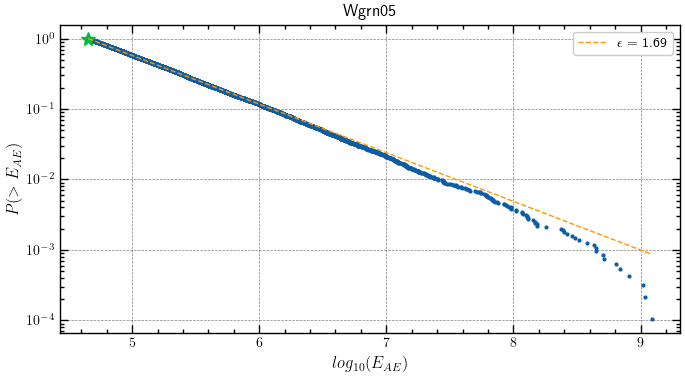

In [21]:
sample = 'Wgrn05'

fit_Exponent = df[sample]['Epsilon']
ccdf = powerlaw.ccdf(df[sample]['Energy'])
mag = np.log10(ccdf[0])
mag_comp = df[sample]['Magnitude of completeness']
index_initial = np.where(mag >= mag_comp)[0][0]
x_initial = mag[index_initial]
y_initial = np.log10(ccdf[1])[index_initial]
m = fit_Exponent - 1.0
y_int = y_initial + m*x_initial

index_final = np.where(mag == max(mag))[0][0]

fig = plt.figure(figsize=(8,4))
cdf = plt.plot(mag,ccdf[1],'.',markersize=4)
plt.plot(x_initial,10**(y_initial),marker='*',markersize=10, linewidth=2)
x = np.linspace(mag[index_initial],mag[index_final])
y = 10**(-m*x + y_int)
plt.plot(x,y,'--',linewidth=1,label='$\epsilon$ = {0}'.format(np.round(fit_Exponent,2)))
plt.yscale('log')
plt.xlabel('$log_{10}(E_{AE})$',size=12)
plt.ylabel('$P(>E_{AE})$',size=12)
plt.tick_params(labelsize=10)
plt.legend(prop={'size':10})
plt.title(sample,size=12)

Our estimate for the power law exponent (for the sample 'Wgrn05') is thus $\epsilon = 1.69$.

#### II.v) Bonus -- Acoustic Emission Hypocenters
As the rock sample is compressed to failure, bursts of acoustic emission events from microcracks occur. These microcracks AE events can be detected in both space in time. The hypocenters is where the AE events occur.

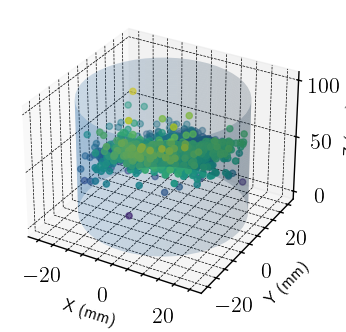

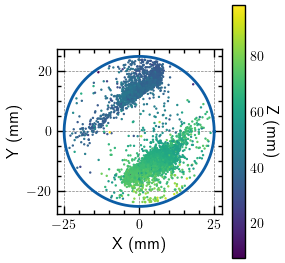

In [22]:
sample = 'Wgrn05'
# Get the spatial coordinates of the microcrack AE events.
X = df[sample]['x']
Y = df[sample]['y']
Z = df[sample]['z']

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    '''
    Creates a cylinder along the z-axis with the specified parameters.
    '''
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# 3D plot -- Hypocenters (x,y,z)
label_size = 12
tick_size = 10
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection='3d')
ax.scatter3D(X,Y,Z,c=Z,rasterized=True)
ax.set_xlabel(r'X (mm)',size = label_size)
ax.set_ylabel(r'Y (mm)',size = label_size)
ax.set_zlabel(r'Z (mm)',size = label_size)
Xc,Yc,Zc = data_for_cylinder_along_z(0,0,25,100)
ax.plot_surface(Xc, Yc, Zc, alpha=0.2,rasterized=True)

# 2D plot -- Epicenters (x,y); no height
fig = plt.figure(figsize=(3,3))
theta = np.linspace(0,2*np.pi,1000)
R = df[sample]['Radius']
rx = 25*np.cos(theta)
ry = 25*(np.sin(theta))

plt.plot(rx,ry)
plt.scatter(X,Y,c=Z,rasterized=True,s=0.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = label_size
cbar.ax.tick_params(labelsize=tick_size)
cbar.ax.set_ylabel('Z (mm)', rotation=270,size=label_size)
plt.ylabel(r'Y (mm)',size=label_size)
plt.xlabel(r'X (mm)',size=label_size)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
plt.gca().set_aspect('equal')

plt.tight_layout()

#### III.i) Approach to Failure
With all the data clean up done, we can finally move onto the brunt of this project: examining the delineation of the temporal evolution of failure characteristics from intact and notched Westerly granite samples; namely, the power law exponent $\epsilon$, the average AE energy $\langle E_{AE} \rangle$, the AE energy rate $dE_{AE}/dt$, and the AE number rate $dN/dt$.

First, we need to split the AE energy into windows of smaller size to capture the AE energy $E_{AE}(t)$ at a particular time $t$, then transform the time variable to one of stress $\sigma$: $E_{AE}(\sigma)$.

In [84]:
def chunking(data, moving_window, window_roll):
    '''
    Description:
    ------------
    Splits data into chunks. 
    
    Parameters:
    -----------
             data: The data the user wants to be chunked.
    moving_window: The size of the chunk.
     window_shift: The shift to the index that begins the next chunk.
     
    Returns:
    --------
           chunks: A 2-D list of the chunked data.
    '''
    chunks = []
    for i in range(0,len(data), window_roll - 1):
        chunks.append(data[i : i + moving_window])

    return chunks

for sample in samples:
    '''
    We want to create a moving window of the data corresponding to a time/stress value to find the temporal evolution.
    Here, we are creating chunks of data called a window, then taking an energy window and finding the power law exponent for that energy window (see II.ii)-II.iv) ).
    '''
    print('======='+sample+'======')
    E = df[sample]['Energy']
    Percent_overlap = 10 # The percent overlap between the moving windows; can be changed.
    Number_of_windows = 17 # The number of moving windows; can be changed.
    moving_window = int(np.floor(1/Number_of_windows*len(E)/(1-Percent_overlap/100)))
    window_shift = int(moving_window*Percent_overlap/100)
    window_roll = int(moving_window - window_shift)

    AE_keys = ['Energy','Time','AdjAmp','Polarity','x','y','z']
    for key in AE_keys:
        print('-----'+key+'------')
        # Creating smaller windows of the data corresponding to a time window.
        x = chunking(df[sample][key],moving_window,window_roll)
        for i in range(0,len(x)):
            print('Chunk...'+str(i),end='\r')
            df[sample][key+str(i)]= x[i]

            if key == 'Energy':
                #Sort the Energy data
                data = np.sort(df[sample]['Energy'+str(i)])
                file_path = 'C:/Users/Drew/Projects/Rock_Fracture/External_Code'
                file_name = 'Energy_sorted.sorted'
                # Save as a file to be input into the fortran code.
                save(data,file_path,file_name) 

                # get the power law exponent map for a shifting energy window, saved as a .EMap file.
                ExponentMap()

                # Load the power law exponent map data.
                Emap = np.loadtxt('Energy_sorted.EMap')
                Emap = np.array(Emap) # Make the data an array.
                Emin = Emap[:,0] # The minimum energy for each energy window.
                Emax = Emap[:,1] # The maximum energy for each energy window.
                Exponent = Emap[:,2] # The power law exponents for each energy window.
                Exponent_error = Emap[:,3] # The error in the power law exponents for each energy window.
                p_value = Emap[:,6] # The p_value for each energy window.

                Largest_Window_Index = np.where(Emax == np.max(Emax))[0] # The index of the largest energy window.
                df[sample]['Emin'+str(i)] = Emin[Largest_Window_Index]
                df[sample]['Exponent'+str(i)] = Exponent[Largest_Window_Index]
                df[sample]['Exponent_error'+str(i)] = Exponent_error[Largest_Window_Index]
                df[sample]['p_value'+str(i)] = p_value[Largest_Window_Index]



=======Wgn19======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------
=======Wgp01======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------
=======Wgr02======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------
=======Wgrn04======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------
=======Wgrn05======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------
=======Wgrn07======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------
=======Wgrn08======
-----Energy------
-----Time------
-----AdjAmp------
-----Polarity------
-----x------
-----y------
-----z------


In [90]:
# Include the cumulative energy and cumulative AE number.
for sample in samples:
    E = df[sample]['Energy']
    
    Percent_overlap = 10 # The percent overlap between the moving windows.
    Number_of_windows = 17 # The number of moving windows.
    moving_window = int(np.floor(1/Number_of_windows*len(E)/(1-Percent_overlap/100)))
    window_shift = int(moving_window*Percent_overlap/100)
    window_roll = int(moving_window - window_shift)
    
    cum_E = np.cumsum(df[sample]['Energy'])
    cum_N = range(0,len(df[sample]['Energy']))
    AE_keys = ['Energy_cum','Number_cum']
    AE_prop = [cum_E,cum_N]
    for k in range(0,len(AE_keys)):
        x = chunking(AE_prop[k],moving_window,window_roll)
        for i in range(0,len(x)):
            df[sample][AE_keys[k]+str(i)]= x[i]

In [86]:
# Split out the data into notched and intact samples.
Notched_Samples = ['Wgrn04','Wgrn05','Wgrn07','Wgrn08','Wgn19']
Intact_Samples = ['Wgp01','Wgr02']

### III.ii) Temporal Evolution of the power law exponent $\epsilon$ 

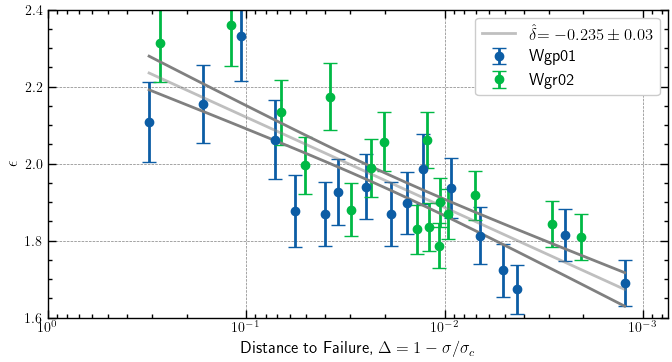

In [411]:

# Plot Parameters
label_size = 12
tick_size = 10

Epsilon_Intact = []
Delta_Intact = []
fig = plt.figure(figsize=(8,4))
for sample in Intact_Samples:    
    Time = np.zeros(Number_of_windows)
    Delta = np.zeros(Number_of_windows)
    Epsilon = np.zeros(Number_of_windows)
    Epsilon_Uncertainty = np.zeros(Number_of_windows)
    for i in range(0,Number_of_windows):
        Time[i] = np.mean(df[sample]['Time'+str(i)])  
        coord = np.where(df[sample]['Time_Force'] > Time[i])[0]
        if len(coord) == 0:
            index = len(df[sample]['Time_Force'])-1
        else:
            index = coord[0]

        Delta[i] = 1-(df[sample]['Diff_stress'][index]/df[sample]['peak_stress']) # The distance to failure.
        Epsilon[i] = df[sample]['Exponent'+str(i)][0]
        Epsilon_Uncertainty[i] = df[sample]['Exponent_error'+str(i)][0]
    
    Epsilon_Intact.append(Epsilon)
    Delta_Intact.append(Delta)

    plt.errorbar(Delta,Epsilon,yerr=Epsilon_Uncertainty,fmt='o',label=sample,capsize=5)
    plt.xscale('log')
    plt.xlim(1,11**-3)
    plt.ylim(1.6,2.4)
    
# Fit the data
def LSQ(x,y,alpha=0.9):
    '''
    Description:
    ------------
    Calculates the confidence interval for a linear regression.

    Parameters:
    -----------
                x: The x data.
                y: The y data.
            alpha: The significance level.

    Returns:
    --------
           CI: The confidence interval.
    '''
    # Set up.
    N = len(x) # Number of data points.
    DoF = N - 2 # Degrees of Freedom.
    indx = np.argsort(x) # Organize the data...
    x0 = x[indx]
    y0 = y[indx]

    # Least Squares Regression.
    [m,yint], cov = np.polyfit(x0,y0,deg=1,cov=True)
    m_err = np.sqrt(cov[0,0])
    y_hat = m*np.array(x0) + yint # The best fit line.

    # Calculate the error.
    resid = (y0 - y)**2
    SEM = np.sqrt(np.std(resid)**2*(1/N + (x0 - np.mean(x0))**2/np.sum((x0 - np.mean(x0))**2)))
    t = stats.t.ppf(alpha, DoF) 
    CI = t*SEM # The confidence interval.

    return x0,y_hat,m,m_err,CI

Delta_Intact = np.array(Delta_Intact).ravel()
df['Delta_Intact'] = Delta_Intact
Epsilon_Intact = np.array(Epsilon_Intact).ravel()
df['Epsilon_Intact'] = Epsilon_Intact
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta_Intact),Epsilon_Intact,alpha=0.9)

def plot_CI(x,y,delta,delta_err,CI,y_label,exp_label,axis=[],x_log=True,y_log=True):
    # log scale --> linear
    if x_log:
        x = 10**x
    if y_log:
        y_CI_plus = 10**(y+CI)
        y_CI_neg = 10**(y-CI)
        y = 10**y
    else:
        y_CI_plus = y+CI
        y_CI_neg = y-CI
        
    if axis == []:
        plt.plot(x,y,label=r'$\hat'+exp_label+r'$ = {0} \pm {1}$'.format(-np.round(delta,3),np.round(delta_err,2)),color='grey',alpha=0.5)
        plt.plot(x,y_CI_plus,color='grey')
        plt.plot(x,y_CI_neg,color='grey')
        plt.legend(prop={'size':label_size})
        plt.ylabel(y_label,size=label_size)
        plt.xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)
        plt.xticks(size=tick_size)
        plt.yticks(size=tick_size)
    else:
        axis.plot(x,y,label=r'$\hat'+exp_label+r'$ = {0} \pm {1}$'.format(-np.round(delta,3),np.round(delta_err,2)),color='grey',alpha=0.5)
        axis.plot(x,y_CI_plus,color='grey')
        axis.plot(x,y_CI_neg,color='grey')
        axis.legend(prop={'size':tick_size-1})
        axis.set_ylabel(y_label,size=label_size)
        axis.set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)
        axis.tick_params(size=tick_size)

plot_CI(x,y,delta,delta_err,CI,r'$\epsilon$',r'\delta$',x_log=True,y_log=False)
plt.show()

Interestingly, the power law exponent $\epsilon$ decreases as intact rock samples approach the failure point. For a critical (power law) exponent to change in a continuous manner as a result of a tuning parameter is what is known as a Griffiths phase in statistical physics, and implies a singular critical point is replaced by an extended critical region.

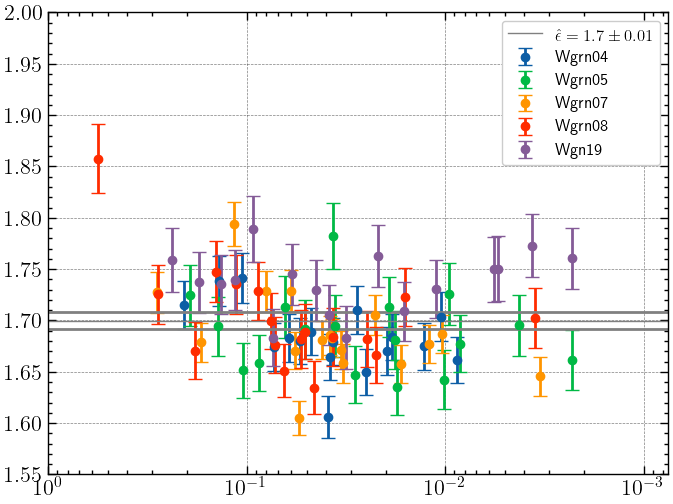

In [403]:
Epsilon_Notched = []
Delta_Notched = []
for sample in Notched_Samples:
    Time = np.zeros(Number_of_windows)
    Delta = np.zeros(Number_of_windows)
    Epsilon = np.zeros(Number_of_windows)
    Epsilon_Uncertainty = np.zeros(Number_of_windows)
    for i in range(0,Number_of_windows):
        Time[i] = np.mean(df[sample]['Time'+str(i)])
        coord = np.where(df[sample]['Time_Force'] > Time[i])[0]
        if len(coord) == 0:
            index = len(df[sample]['Time_Force'])-1
        else:
            index = coord[0]

        Delta[i] = 1-(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])
        Epsilon[i] = df[sample]['Exponent'+str(i)][0]
        Epsilon_Uncertainty[i] = df[sample]['Exponent_error'+str(i)][0]
    
    Epsilon_Notched.append(Epsilon)
    Delta_Notched.append(Delta)

    plt.errorbar(Delta,Epsilon,Epsilon_Uncertainty,fmt='o',label=sample,capsize=5)
    plt.xscale('log')
    plt.xlim(1,11**-3)
    plt.ylim(1.55,2)

# Fit the data
Delta_Notched = np.array(Delta_Notched).ravel()
df['Delta_Notched'] = Delta_Notched
Epsilon_Notched = np.array(Epsilon_Notched).ravel()
df['Epsilon_Notched'] = Epsilon_Notched
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta_Notched),Epsilon_Notched,alpha=0.9)

resid = (Epsilon_Notched - np.mean(Epsilon_Notched))**2
N = len(Epsilon_Notched)
SEM = np.sqrt(np.std(resid)/N)
t = stats.t.ppf(0.9, N-2) 
CI = t*SEM # The confidence interval.
CI

plt.axhline(np.mean(y),color='grey',label=r'$\hat\epsilon = {0} \pm {1}$'.format(np.round(np.mean(y),2),np.round(np.std(y),2)),linewidth=1)
plt.axhline(np.mean(y)+CI,color='grey',linewidth=2)
plt.axhline(np.mean(y)-CI,color='grey',linewidth=2)
#plot_CI(x,y,delta,delta_err,CI,r'$\epsilon$',r'\delta$',x_log=True,y_log=False)
plt.legend(prop={'size':label_size})
plt.show()

The notched samples, on the contrary to the intact samples, show a statistically stationary power law exponent.

### III.iii) Temporal Evolution of the Average AE Energy, AE Energy Rate, and AE Number Rate.

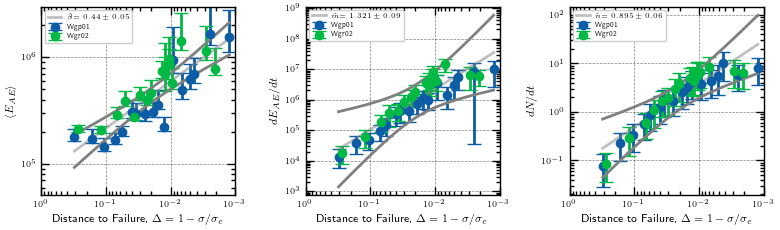

In [424]:
def bs_to_array(string):
    '''
    Name says it all. This functions take the type bootstrap and converts it into a working numpy array
    containing the 90% convidence interval and by extension the uncertainty to be used.
    '''
    string = str(string)
    first_split = re.split(r'\(',string)
    second_split = re.split(r'\)',first_split[1])
    third_split = re.split(r'\,',second_split[0])
    string_array = np.array(third_split)
    int_array = []
    for i in range(len(string_array)):
        int_array.append(float(string_array[i]))
    return np.array(int_array)

def Confidence_Interval(array, alpha = 0.1, func = 'std'):
    '''
    This function will return a ((1 - alpha)*100)% confidence interval of a selected array.
    '''
    
    if func == 'std':
        bs_C_I_interval = bs.bootstrap(np.array(array), alpha = alpha, stat_func = bs_stats.std, num_iterations=100)
    else:
        bs_C_I_interval = bs.bootstrap(np.array(array), alpha = alpha, stat_func = bs_stats.mean, num_iterations=100)
    C_I = bs_to_array(bs_C_I_interval)
    return C_I

# Plot Parameters.
label_size = 8
tick_size = 6

dE_dt0 = []
dN_dt0 = []
E_avg0 = []
Delta0 = []
Emax0 = []

fig,ax = plt.subplots(1,3,figsize=(8,2.5))
for sample in Intact_Samples:
    dE_dt = np.zeros(Number_of_windows)
    dE_dt_Uncertainty = np.zeros([Number_of_windows,2])
    dN_dt = np.zeros(Number_of_windows)
    dN_dt_Uncertainty = np.zeros([Number_of_windows,2])
    E_avg = np.zeros(Number_of_windows)
    E_avg_Uncertainty = np.zeros([Number_of_windows,2])
    Delta = np.zeros(Number_of_windows)
    E_max = np.zeros(Number_of_windows)

    #Delta_Uncertainty = np.zeros(Number_of_windows)
    for i in range(0,Number_of_windows):
        Time[i] = np.mean(df[sample]['Time'+str(i)])
        coord = np.where(df[sample]['Time_Force'] > Time[i])[0]
        if len(coord) == 0:
            index = len(df[sample]['Time_Force'])-1
        else:
            index = coord[0]

        Delta[i] = 1-(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])
        #Delta_Uncertainty[i] = Confidence_Interval(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])

        cum_Energy = df[sample]['Energy_cum'+str(i)]#np.cumsum(df[sample]['Energy'+str(i)])
        cum_N = df[sample]['Number_cum'+str(i)]#np.cumsum(range(0,len(df[sample]['Energy'])))
        T = df[sample]['Time'+str(i)]

        #test = np.cumsum(df[sample]['Energy'])
        L_E = len(cum_Energy)
        E1 = np.mean(cum_Energy[0:int(L_E/2)])
        E1_Uncertainty = Confidence_Interval(cum_Energy[0:int(L_E/2)])
        E2 = np.mean(cum_Energy[int(L_E/2):L_E])
        E2_Uncertainty = Confidence_Interval(cum_Energy[int(L_E/2):L_E])
        dE = E2 - E1
        dE_Uncertainty = np.sqrt(E1_Uncertainty**2 + E2_Uncertainty**2)

        N1 = np.mean(cum_N[0:int(L_E/2)])
        N1_Uncertainty = Confidence_Interval(cum_N[0:int(L_E/2)])
        N2 = np.mean(cum_N[int(L_E/2):L_E])
        N2_Uncertainty = Confidence_Interval(cum_N[int(L_E/2):L_E])
        dN = N2 - N1
        dN_Uncertainty = np.sqrt(N1_Uncertainty**2 + N2_Uncertainty**2)

        t1 = np.mean(T[0:int(L_E/2)])
        t1_Uncertainty = Confidence_Interval(T[0:int(L_E/2)])
        t2 = np.mean(T[int(L_E/2):L_E])
        t2_Uncertainty = Confidence_Interval(T[int(L_E/2):L_E])
        dt = t2 - t1
        dt_Uncertainty = np.sqrt(t1_Uncertainty**2 + t2_Uncertainty**2)


        dE_dt[i] = dE/dt
        dE_dt_Uncertainty[i,:] = np.sqrt((dE_Uncertainty/dt)**2 + (dE*dt_Uncertainty/dt**2)**2)
        dN_dt[i] = dN/dt
        dN_dt_Uncertainty[i,:] = np.sqrt((dN_Uncertainty/dt)**2 + (dN*dt_Uncertainty/dt**2)**2)
    
        E_avg[i] = np.mean(df[sample]['Energy'+str(i)])
        E_avg_Uncertainty[i,:] = Confidence_Interval(df[sample]['Energy'+str(i)])/np.sqrt(len(df[sample]['Energy'+str(i)]))

        E_max[i] = max(df[sample]['Energy'+str(i)])

    # Average Energy
    ax[0].errorbar(Delta,E_avg,yerr=np.array(E_avg_Uncertainty).T,fmt='o',label=sample,capsize=5)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlim(1,10**-3)
    ax[0].set_ylim(15**4,12**6)
    ax[0].tick_params(labelsize=tick_size)
    ax[0].set_ylabel('$\langle E_{AE} \\rangle$',size=label_size)
    ax[0].set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)
    #ax[0].legend(prop={'size':label_size})

    # Energy Rate
    ax[1].errorbar(Delta,dE_dt,yerr=np.array(dE_dt_Uncertainty).T,fmt='o',label=sample,capsize=5)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(1,10**-3)
    ax[1].tick_params(labelsize=tick_size)
    #ax[1].ylim(10**5,14**6)
    ax[1].set_ylabel('$dE_{AE}/dt$',size=label_size)
    ax[1].set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)

    # Number Rate
    ax[2].errorbar(Delta,dN_dt,yerr=np.array(dN_dt_Uncertainty).T,fmt='o',label=sample,capsize=5)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlim(1,10**-3)
    ax[2].tick_params(labelsize=tick_size)
    ax[2].set_ylabel('$dN_{AE}/dt$',size=label_size)
    ax[2].set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)
    #ax[2].ylim(10**5,14**6)
    #ax[2].

    dE_dt0.append(dE_dt)
    dN_dt0.append(dN_dt)
    E_avg0.append(E_avg)
    Delta0.append(Delta)
    Emax0.append(E_max)

# Fit the data
Delta = np.array(Delta0).ravel()
E_avg = np.array(E_avg0).ravel()
E_max = np.array(Emax0).ravel()
df['Extreme_Energy_Intact'] = E_max

# Plot of the Average AE Energy.
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta),np.log10(E_avg),alpha=0.9)
plot_CI(x,y,delta,delta_err,CI,'$\langle E_{AE} \\rangle$',r'\beta$',ax[0],x_log=True,y_log=True)

# Plot of the AE Energy Rate.
Delta = np.array(Delta0).ravel()
dE_dt = np.array(dE_dt0).ravel()
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta),np.log10(dE_dt),alpha=0.9)
plot_CI(x,y,delta,delta_err,CI,'$dE_{AE}/dt$',r'{m}$',ax[1],x_log=True,y_log=True)

# Plot of the AE Number Rate.
Delta = np.array(Delta0).ravel()
dN_dt = np.array(dN_dt0).ravel()
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta),np.log10(dN_dt),alpha=0.9)
plot_CI(x,y,delta,delta_err,CI,'$dN/dt$',r'{n}$',ax[2],x_log=True,y_log=True)

plt.tight_layout()

In each characteristic, there's a divergence. What's important is the average energy diverges implying a divergence of characteristic scales and critical failure. We can also see that the addition of the exponents for the AE average energy and the AE number rate sum to within error of the AE energy rate. This is in line with our prediction and model:

\begin{align}
    \dfrac{dE_{AE}}{dt} = \dfrac{dE_{AE}}{dN}\dfrac{dN}{dt} = \langle E_{AE} \rangle\dfrac{dN}{dt} \nonumber
\end{align}

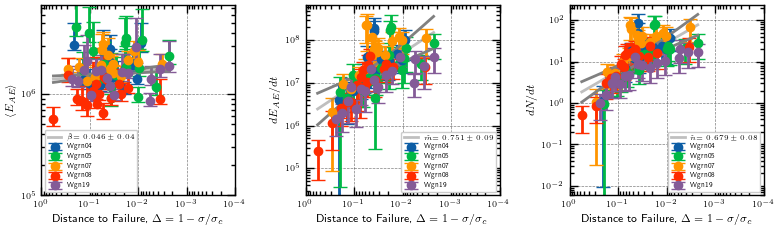

In [425]:

dE_dt0 = []
dN_dt0 = []
E_avg0 = []
Delta0 = []
Emax0 = []

fig,ax = plt.subplots(1,3,figsize=(8,2.5))
for sample in Notched_Samples:
    dE_dt = np.zeros(Number_of_windows)
    dE_dt_Uncertainty = np.zeros([Number_of_windows,2])
    dN_dt = np.zeros(Number_of_windows)
    dN_dt_Uncertainty = np.zeros([Number_of_windows,2])
    E_avg = np.zeros(Number_of_windows)
    E_avg_Uncertainty = np.zeros([Number_of_windows,2])
    Delta = np.zeros(Number_of_windows)
    Emax = np.zeros(Number_of_windows)
    #Delta_Uncertainty = np.zeros(Number_of_windows)
    for i in range(0,Number_of_windows):
        Time[i] = np.mean(df[sample]['Time'+str(i)])
        coord = np.where(df[sample]['Time_Force'] > Time[i])[0]
        if len(coord) == 0:
            index = len(df[sample]['Time_Force'])-1
        else:
            index = coord[0]

        Delta[i] = 1-(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])
        #Delta_Uncertainty[i] = Confidence_Interval(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])

        cum_Energy = df[sample]['Energy_cum'+str(i)]
        cum_N = df[sample]['Number_cum'+str(i)]
        T = df[sample]['Time'+str(i)]

        #test = np.cumsum(df[sample]['Energy'])
        L_E = len(cum_Energy)
        E1 = np.mean(cum_Energy[0:int(L_E/2)])
        E1_Uncertainty = Confidence_Interval(cum_Energy[0:int(L_E/2)])
        E2 = np.mean(cum_Energy[int(L_E/2):L_E])
        E2_Uncertainty = Confidence_Interval(cum_Energy[int(L_E/2):L_E])
        dE = E2 - E1
        dE_Uncertainty = np.sqrt(E1_Uncertainty**2 + E2_Uncertainty**2)

        N1 = np.mean(cum_N[0:int(L_E/2)])
        N1_Uncertainty = Confidence_Interval(cum_N[0:int(L_E/2)])
        N2 = np.mean(cum_N[int(L_E/2):L_E])
        N2_Uncertainty = Confidence_Interval(cum_N[int(L_E/2):L_E])
        dN = N2 - N1
        dN_Uncertainty = np.sqrt(N1_Uncertainty**2 + N2_Uncertainty**2)

        t1 = np.mean(T[0:int(L_E/2)])
        t1_Uncertainty = Confidence_Interval(T[0:int(L_E/2)])
        t2 = np.mean(T[int(L_E/2):L_E])
        t2_Uncertainty = Confidence_Interval(T[int(L_E/2):L_E])
        dt = t2 - t1
        dt_Uncertainty = np.sqrt(t1_Uncertainty**2 + t2_Uncertainty**2)


        dE_dt[i] = dE/dt
        dE_dt_Uncertainty[i,:] = np.sqrt((dE_Uncertainty/dt)**2 + (dE*dt_Uncertainty/dt**2)**2)
        dN_dt[i] = dN/dt
        dN_dt_Uncertainty[i,:] = np.sqrt((dN_Uncertainty/dt)**2 + (dN*dt_Uncertainty/dt**2)**2)
    
        E_avg[i] = np.mean(df[sample]['Energy'+str(i)])
        E_avg_Uncertainty[i,:] = Confidence_Interval(df[sample]['Energy'+str(i)])/np.sqrt(len(df[sample]['Energy'+str(i)]))
    
        Emax[i] = max(df[sample]['Energy'+str(i)])

    # Average Energy
    ax[0].errorbar(Delta,E_avg,yerr=np.array(E_avg_Uncertainty).T,fmt='o',label=sample,capsize=5)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlim(1,10**-4)
    ax[0].set_ylim(10**5,14**6)
    ax[0].tick_params(labelsize=tick_size)
    ax[0].set_ylabel('$\langle E_{AE} \\rangle$',size=label_size)
    ax[0].set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)

    # Energy Rate
    ax[1].errorbar(Delta,dE_dt,yerr=np.array(dE_dt_Uncertainty).T,fmt='o',label=sample,capsize=5)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(1,10**-4)
    ax[1].tick_params(labelsize=tick_size)
    #ax[1].ylim(10**5,14**6)
    ax[1].set_ylabel('$dE_{AE}/dt$',size=label_size)
    ax[1].set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)

    # Number Rate
    ax[2].errorbar(Delta,dN_dt,yerr=np.array(dN_dt_Uncertainty).T,fmt='o',label=sample,capsize=5)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlim(1,10**-4)
    ax[2].tick_params(labelsize=tick_size)
    #ax[2].ylim(10**5,14**6)
    ax[2].set_ylabel('$dN_{AE}/dt$',size=label_size)
    ax[2].set_xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)

    dE_dt0.append(dE_dt)
    dN_dt0.append(dN_dt)
    E_avg0.append(E_avg)
    Delta0.append(Delta)
    Emax0.append(Emax)

# Fit the data
Delta = np.array(Delta0).ravel()
E_avg = np.array(E_avg0).ravel()
E_max = np.array(Emax0).ravel()
df['Extreme_Energy_Notched'] = E_max
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta),np.log10(E_avg),alpha=0.9)
plot_CI(x,y,delta,delta_err,CI,'$\langle E_{AE} \\rangle$',r'\beta$',ax[0],x_log=True,y_log=True)

Delta = np.array(Delta0).ravel()
dE_dt = np.array(dE_dt0).ravel()
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta),np.log10(dE_dt),alpha=0.9)
plot_CI(x,y,delta,delta_err,CI,'$dE_{AE}/dt$',r'{m}$',ax[1],x_log=True,y_log=True)

Delta = np.array(Delta0).ravel()
dN_dt = np.array(dN_dt0).ravel()
[x,y,delta,delta_err,CI] = LSQ(np.log10(Delta),np.log10(dN_dt),alpha=0.9)
plot_CI(x,y,delta,delta_err,CI,'$dN/dt$',r'{n}$',ax[2],x_log=True,y_log=True)

plt.tight_layout()

Here, the notched samples show a statistically stationary average AE energy, suggesting no critical failure. Yet, there is still an increase in the AE energy rate and thus an accelerated seismic release. Such a case is enough to imply that accelerated seismic release can indeed be independent of critical failure dynamics, and still follows our model:

\begin{align}
    \dfrac{dE_{AE}}{dt} = \langle E_{AE} \rangle \dfrac{dN}{dt} \nonumber.
\end{align}

Where $\langle E_{AE} \rangle$ is not necessary for the divergence of $\dfrac{dE_{AE}}{dt}, and if such a case were to occur, need only be completely dependent on the divergence of AE number rate. More specifically, the two divergences would be proportionally equivalent:

\begin{align}
    \dfrac{dE_{AE}}{dt} \propto \dfrac{dN}{dt} \nonumber
\end{align}

We see this equivalency in the exponents: $\hat{m} \sim \hat{n}$ to within statistical error.


### III.iv) Tensile, Shear, Compaction -- Temporal Evolution of the AE type (Polarity)


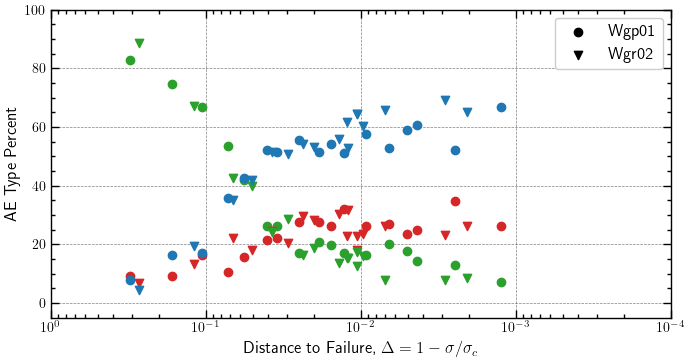

In [99]:
def Polarity_Type(polarity):
        if polarity <= -0.25:
            return 'tensile'
        elif polarity >= 0.25:
            return 'compact'
        else:
            return 'shear'

def Event_Type_Percent(df,sample):
    '''
    This function takes a chunk of events and returns the percent of all their types, based on its polarity.
    '''
        
    category_list = []  # A list for each type percent per chunk
    Type_list = ['tensile','compact','shear']
    for i in range(Number_of_windows):
        Percent_list = []
        category = {'tensile':0, 'compact':0, 'shear':0}
        for j in range(len(df[sample]['Polarity'+str(i)])):
            category[Polarity_Type(df[sample]['Polarity'+str(i)][j])] += 1
        for k in range(len(Type_list)):
            Percent = np.round(category[Type_list[k]]/len(df[sample]['Polarity'+str(i)])*100,3)
            category[Type_list[k]] = Percent
        category_list.append(category)
    
    return category_list

markers = ['o','v']

fig = plt.figure(figsize=(8,4))
sample_counter = 0
for sample in Intact_Samples:
    category_list = Event_Type_Percent(df,sample)

    shear = []
    tensile = []
    compact = []
    for i in range(len(category_list)):
        shear.append(category_list[i]['shear'])
        tensile.append(category_list[i]['tensile'])
        compact.append(category_list[i]['compact'])

    Delta = np.zeros(Number_of_windows)
    for i in range(Number_of_windows):
        Time = np.mean(df[sample]['Time'+str(i)])
        coord = np.where(df[sample]['Time_Force'] > Time)[0]
        if len(coord) == 0:
            index = len(df[sample]['Time_Force'])-1
        else:
            index = coord[0]
        Delta[i] = 1-(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])

    # Plot Parameters.
    label_size = 12
    tick_size = 10

    plt.scatter(Delta,shear,marker=markers[sample_counter],color='tab:red')
    plt.scatter(Delta,tensile,marker=markers[sample_counter],color='tab:green')
    plt.scatter(Delta,compact,marker=markers[sample_counter],color='tab:blue')
    plt.xlim(1,10**-4)
    plt.xscale('log')
    plt.xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)
    plt.ylabel('AE Type Percent',size=label_size)
    plt.xticks(size=tick_size)
    plt.yticks(size=tick_size)
    plt.ylim(-5,100)
    plt.scatter([],[],label=sample,marker=markers[sample_counter],color='black')
    sample_counter += 1
plt.legend(prop={'size':label_size})
plt.show()

The intact samples show
an initially large proportion of tensile-type AE events. As the
failure point is approached, the tensile events are significantly
reduced and compaction events become dominant with a maximum value of around 60%. 

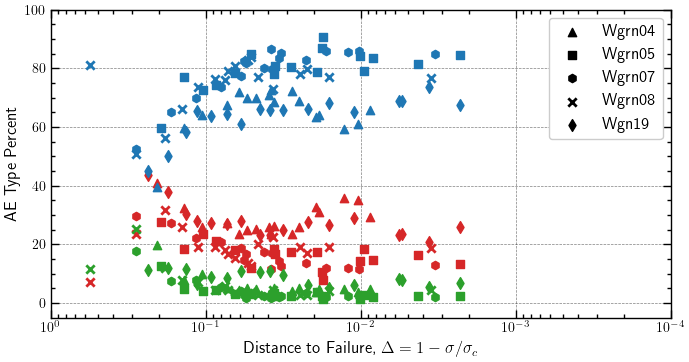

In [100]:
markers = ['^','s','h','x','d']

fig = plt.figure(figsize=(8,4))
sample_counter = 0
for sample in Notched_Samples:
    category_list = Event_Type_Percent(df,sample)

    shear = []
    tensile = []
    compact = []
    for i in range(len(category_list)):
        shear.append(category_list[i]['shear'])
        tensile.append(category_list[i]['tensile'])
        compact.append(category_list[i]['compact'])

    Delta = np.zeros(Number_of_windows)
    for i in range(Number_of_windows):
        Time = np.mean(df[sample]['Time'+str(i)])
        coord = np.where(df[sample]['Time_Force'] > Time)[0]
        if len(coord) == 0:
            index = len(df[sample]['Time_Force'])-1
        else:
            index = coord[0]
        Delta[i] = 1-(df[sample]['Diff_stress'][index]/df[sample]['peak_stress'])

    # Plot Parameters.
    label_size = 12
    tick_size = 10

    plt.scatter(Delta,shear,marker=markers[sample_counter],color='tab:red')
    plt.scatter(Delta,tensile,marker=markers[sample_counter],color='tab:green')
    plt.scatter(Delta,compact,marker=markers[sample_counter],color='tab:blue')
    plt.xlim(1,10**-4)
    plt.xscale('log')
    plt.xlabel('Distance to Failure, $\Delta = 1 - \sigma/\sigma_{c}$',size=label_size)
    plt.ylabel('AE Type Percent',size=label_size)
    plt.xticks(size=tick_size)
    plt.yticks(size=tick_size)
    plt.ylim(-5,100)
    plt.scatter([],[],label=sample,marker=markers[sample_counter],color='black')
    sample_counter += 1
plt.legend(prop={'size':label_size})
plt.show()

In contrast, the notched samples show a large proportion of compaction events throughout with very little variation during the final approach to failure, reaching a proportion of between 60% and 80% depending on the sample. 

### III.v) Event-Event Triggering: the Bi Test

If AE events are independent of one another then their
occurrence in time would follow a Poisson process. Under this
main assumption being our null hypothesis, we can define different measures to statistically determine whether deviations
from Poisson behavior and potentially event-event triggering
and aftershocks are present in our samples. A method looking
into testing the null hypothesis of a Poisson process is the Bi
test. 

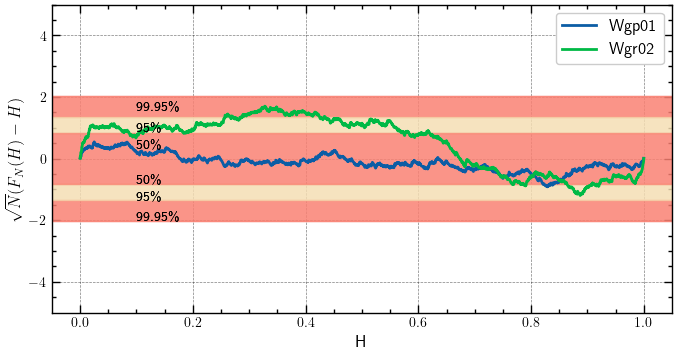

In [130]:
def Bi_test():

    #trigger_list = np.array(data_thres(Time[sample][index_start:index_end],Energy[sample][index_start:index_end],mag_thres[sample]))
    trigger_list = df[sample]['Time']
    Time_Interval_list = np.diff(trigger_list)

    tau = []
    tau_plus = []
    for i in range(len(Time_Interval_list)):
        if i == 0.0 or i == len(Time_Interval_list) - 2 or i == len(Time_Interval_list) - 1:
            continue
        if Time_Interval_list[i+1] < Time_Interval_list[i]:
            tau.append(Time_Interval_list[i+1])
            tau_plus.append(Time_Interval_list[i+2])
        else:
            tau.append(Time_Interval_list[i])
            tau_plus.append(Time_Interval_list[i-1])
    H = np.array(tau)/(np.array(tau) + 0.5*np.array(tau_plus))
    
    return H

def ecdf(data):
    '''
    Get the CDF.
    '''
    x, counts = np.unique(data, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

# Find the alpha = 0.001 or 99.95% CI

def plot_Bi(sample):
    alpha = [0.0005,0.05,0.5]
    D_Crit_vals = []
    for i in range(len(alpha)):
        D_Crit_vals.append(np.sqrt(-np.log(alpha[i]/2)*0.5))

    H = Bi_test()
    H, F_N_H = ecdf(H)
    D_N = max(np.abs(F_N_H - H))
    #print(r'statistic = ',D_N)
    p_value = scipy.stats.kstest(H,'uniform')[1]
        
    KS_test = np.sqrt(len(H))*(F_N_H - H)

    color_list = ['salmon','wheat','salmon']
    CI_list = ['99.95\%','95\%','50\%']
    for i in range(len(D_Crit_vals)):
        if i == len(D_Crit_vals) - 1:
            plt.axhspan(D_Crit_vals[i], -D_Crit_vals[i], color=color_list[i],alpha=0.6)
            plt.text(0.1,D_Crit_vals[i]-0.5,CI_list[i],size=tick_size)
            plt.text(0.1,-D_Crit_vals[i],CI_list[i],size=tick_size)
        else:
            plt.axhspan(D_Crit_vals[i], D_Crit_vals[i+1], color=color_list[i],alpha=0.6)
            plt.axhspan(-D_Crit_vals[i], -D_Crit_vals[i+1], color=color_list[i],alpha=0.6)
            plt.text(0.1,D_Crit_vals[i]-0.5,CI_list[i],size=tick_size)
            plt.text(0.1,-D_Crit_vals[i],CI_list[i],size=tick_size)
            

            
    plt.plot(H,KS_test,label=sample)
    plt.ylim(-5,5)
    plt.xticks(size=tick_size)
    plt.yticks(size=tick_size)
    plt.xlabel(r'H',size=label_size)
    plt.ylabel(r'$\sqrt{N}(F_{N}(H) - H)$',size=label_size)

fig = plt.figure(figsize=(8,4))
for sample in Intact_Samples:
    plot_Bi(sample)
    plt.legend(prop={'size':label_size})



For a Poisson process, the resultant curve should hover around 0. If there is regularity in the time intervals, then the resultant curve will look like a rotated $90^{\circ}$ clockwise $S$ shape. Indeed, we observe here a weak $S$ shape for the intact samples, indictative of regularity but not so much of outright rejecting the Poisson process. We can say within a confidence level of 95% that the intact samples do not exhibit any statistically noticeable signs of event-event triggering. 

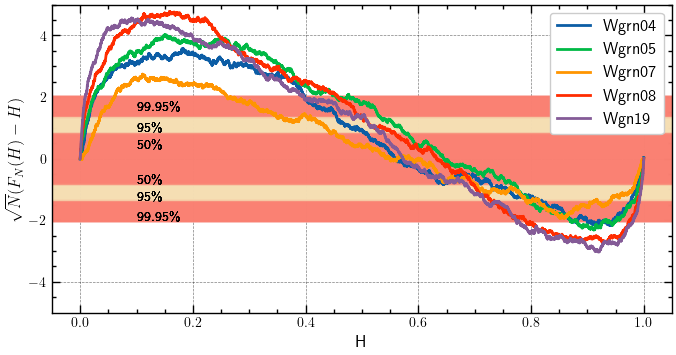

In [133]:
fig = plt.figure(figsize=(8,4))
for sample in Notched_Samples:
    plot_Bi(sample)
    plt.legend(prop={'size':label_size})
    

When there is an excess of H values around 0 or 1, it indicates temporal clustering of the AE events, and the resultant curve will look like a rotated $90^{\circ}$ clockwise $Z$ shape.
Therefore, if a resultant curve is this $Z$ shape, then, statistically, it is indicative of triggering being present in the
sample. The notched samples are well outside our confidence interval and exhibit a quite-established $Z$ shape. This suggests that the notched samples had event-event triggering present during the fracturing experiment.

---
### Conclusion:

To establish the differences in the brittle failure characteristics that occur due to large-scale heterogeneities, we analyzed the temporal evolution of four AE-derived parameters from a series of triaxial fracture experiments performed on Westerly granite samples at constant loading rate and confining pressure. We found that accelerated seismic release (ASR) without critical failure is present for experiments with large structural inhomogeneities in the form of notches: In all notched sample cases, the temporal
evolution of $\epsilon$ is stationary, yet the system still exhibits a divergence of total AE energy and, hence, ASR during the approach to failure as a consequence of the divergence of the AE event rates. In contrast, the intact samples exhibit ASR in addition to a decreasing $\epsilon$ consistent with a Griffiths phase. The combination of these two features leads to a much more rapid approach to failure as manifested in a larger value of the ASR exponent $m$ compared to the notched cases. At the same time, the exponent $n$ is statistically indistinguishable between the two cases. 

In terms of predictive power, the increase in average event energy or, more precisely, the decreasing  in the lead up to failure in intact samples provides in principle a second independent way, in addition to ASR, to predict compressive failure. Interestingly, the value of at which failure occurs in our intact samples is statistically indistinguishable from the (stationary) value observed in the notched cases, $\epsilon \sim 1.7$.

Event-event triggering and aftershocks are typically more prevalent in notched samples during loading than in intact samples. We have verified this for all experiments directly by using, for example, the Bi test. This suggests that there might be a relation between the prevalence of event-event triggering or aftershocks during loading and the type of failure.

Our findings certainly show that the presence of a notch significantly alters the evolution of AE kinematics leading to dominant compaction events. Future experimental work is necessary to test the hypothesis of transient hardening directly.